In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
model_chkpt_path = '../checkpoints/hyperSN/'
model_name = "eager-armadillo-115"
model_chkpt_name = "best_model.ckpt"

# move to the model directory
os.chdir(os.path.join(model_chkpt_path, model_name))

from scripts import dataloader, hyperSN_model

In [3]:
model = hyperSN_model.HyperSN.load_from_checkpoint(model_chkpt_name, strict=False)
model = model.to(model.device)
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/stude/OneDrive/Anlagen/Dokumente/I4DS/Biocyle/Repository/3D-CNN-Pixelclassifier/checkpoints/hyperSN/eager-armadillo-115/best_model.ckpt'

In [3]:
path_val = "C:/Users/stude/OneDrive/Anlagen/Dokumente/I4DS/Biocyle/Repository/biocycle/data/processed/bcd_val/data"
path_pca = "C:/Users/stude/OneDrive/Anlagen/Dokumente/I4DS/Biocyle/Repository/3D-CNN-Pixelclassifier/models/hyperSN/pca"

dataloader = dataloader.HyperspectralDataset(path_data=path_val, 
                                             window_size=model.hparams.patch_size,
                                             stride=1,
                                             in_channels=model.hparams.in_channels,
                                             mode='test',
                                             sample_strategy='grid',
                                             gradient_masking=True,
                                             pca_model_path=path_pca
                                             )

Loading PCA model from file: C:/Users/stude/OneDrive/Anlagen/Dokumente/I4DS/Biocyle/Repository/3D-CNN-Pixelclassifier/models/hyperSN/pca\32_pca.pkl


C:\Users\stude\anaconda3\envs\biocycling_px\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator IncrementalPCA from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
iterator = dataloader.iterate_full_cube()

In [5]:
window, mask, cube_index, i, j = next(iterator)

Loading cube 0 from E0051


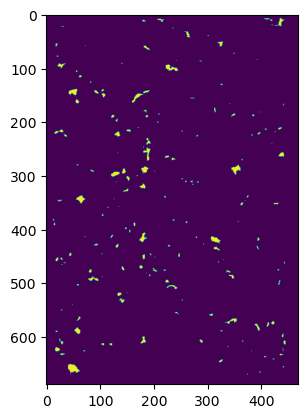

In [6]:
batch_size = 2042  # Define your batch size
windows_batch = []
indices_batch = []

img_result = np.zeros(dataloader.current_cube.shape[:2])
for n in range(img_result.shape[0]*img_result.shape[1]//batch_size+1):
    for m in range(batch_size):
        try:
            window, mask, cube_index, i, j = next(iterator)
            windows_batch.append(window)
            indices_batch.append((i, j))
        except StopIteration:
            break

    # If batch is full, process it
    if len(windows_batch) == batch_size:
        # Convert windows batch to tensor
        windows_tensor = torch.from_numpy(np.array(windows_batch))
        windows_tensor = windows_tensor.unsqueeze(1).float().to(model.device)

        # Process the batch
        results = model.forward_pass(windows_tensor)
        results = results.squeeze(1).cpu().detach().numpy()
        results = np.argmax(results, axis=1)

        # Update img_result with batch results
        for idx, result in zip(indices_batch, results):
            img_result[idx[0], idx[1]] = result

        # Clear the batches
        windows_batch.clear()
        indices_batch.clear()

# Process the remaining windows in the batch (if any)
if windows_batch:
    # Convert windows batch to tensor
    windows_tensor = torch.from_numpy(np.array(windows_batch))
    windows_tensor = windows_tensor.unsqueeze(1).float().to(model.device)

    # Process the batch
    results = model.forward_pass(windows_tensor)
    results = results.squeeze(1).cpu().detach().numpy()
    results = np.argmax(results, axis=1)

    # Update img_result with batch results
    for idx, result in zip(indices_batch, results):
        img_result[idx[0], idx[1]] = result

plt.imshow(img_result)

In [7]:
plt.imsave('output.png', img_result, cmap='viridis')